In [1]:
# !curl https://cdn.iconicto.com/Speculo/fingerprinter/datasets/test_set.tar.gz -o test_set.tar.gz
# !curl https://cdn.iconicto.com/Speculo/fingerprinter/datasets/train_set.tar.gz -o train_set.tar.gz

In [2]:
# !tar -xf test_set.tar.gz
# !tar -xf train_set.tar.gz

In [3]:
# %tensorflow_version 2.x
# import os
# import pickle
# import random
# from tqdm import tqdm

# BASE_DIR = ""

# data = []
# if not os.path.isdir(os.path.join(BASE_DIR, "dataset_processed")):
#     raise FileNotFoundError("fingerprinter/dataset_processed was not found")
# for person in tqdm(os.listdir(os.path.join(BASE_DIR, "dataset_processed"))):
#     for Y in os.listdir(os.path.join(BASE_DIR, "dataset_processed", person, "Y")):
#         for X in os.listdir(os.path.join(BASE_DIR, "dataset_processed", person, "X")):
#             if X.split(".")[0].split("_")[-1] == Y.split(".")[0].split("_")[-1]:
#                 data.append([os.path.join(BASE_DIR, "dataset_processed", person, "X", X),
#                              os.path.join(BASE_DIR, "dataset_processed", person, "Y", Y)])


# random.shuffle(data)
# if not os.path.isdir(os.path.join(BASE_DIR, "dataset")):
#     os.makedirs(os.path.join(BASE_DIR, "dataset"))
# file = open(os.path.join(BASE_DIR, "dataset", "youtube_data_map.pkl"), 'wb')
# pickle.dump(data, file)
# file.close()


In [4]:
import pickle
from sklearn.utils import shuffle
from PIL import Image
import os
import numpy as np
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv2DTranspose, \
    MaxPooling2D, BatchNormalization, Flatten, Reshape, Activation, Dropout
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, load_model
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from tensorflow import keras


class AutoEncoderProgress(keras.callbacks.Callback):
    def __init__(self, model, n_epoch=1):
        super().__init__()
        self.speculo = model
        self.n_epoch = n_epoch

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.n_epoch == 0:
            self.speculo.evaluate(f'Model Predictions on epoch {epoch}',
                                  f'models/{self.speculo.model_number}/img/predictions-epoch-{epoch:03d}.png')
        if os.path.isfile(".stop_training"):
            print("Stopping training because .stop_training was found")
            self.model.stop_training = True


class Speculo:
    def __init__(self, image_size=(32, 32, 1), model_path=None, visualize=True, batch_size=64):
        self.optimizer = 'adam'
        self.loss_function = 'binary_crossentropy'
        self.LR = 1e-3

        self.filters = (64, 128, 256, 512, 1024)[::-1]
        self.latent_size = 4096
        
        self.image_size = image_size
        self.model_path = model_path
        self.visualize = visualize
        self.dataset_size = 0
        self.batch_size = batch_size
        self.batches_per_step = 4

        model_number = 1
        if os.path.isdir("models"):
            model_number += len(os.listdir("models"))

        self.model_number = f"{model_number}"

        self.model = None

    def _build_model(self):
        input_img = Input(shape=self.image_size, name="input")
        x = input_img

        for f in self.filters:
            x = Conv2D(f, (3, 3), activation='relu', padding='same')(x)
            x = MaxPooling2D((2, 2))(x)
            x = Dropout(0.1)(x)

        size = K.int_shape(x)
        x = Flatten()(x)
        x = Dropout(0.2)(x)
        x = Dense(self.latent_size, name="latent_space")(x)

        x = Dense(np.prod(size[1:]))(x)
        x = Reshape((size[1], size[2], size[3]))(x)

        for f in self.filters[::-1]:
            x = Conv2DTranspose(f, (3, 3), strides=2, activation='relu', padding='same')(x)
            x = BatchNormalization()(x)
            x = Dropout(0.1)(x)

        x = Conv2DTranspose(self.image_size[2], (3, 3), activation='relu', padding='same')(x)
        output = Activation("sigmoid", name="output")(x)

        return Model(inputs=input_img, outputs=output, name=f"Speculo-v{self.model_number}")

    def autoencoder(self):
        autoencoder = self._build_model()
        autoencoder.compile(optimizer=self.optimizer, loss=self.loss_function)
        return autoencoder

    def display_image_array(self, n, *image_sets, figsize=(8, 4), title=None, labels=None, save_dir=None):
        plt.figure(figsize=figsize)
        if title:
            plt.suptitle(title)
        i = 1
        row = 0
        if labels and len(labels) != len(image_sets):
            labels = None
        for image_set in image_sets:
            for x in range(n):
                ax = plt.subplot(len(image_sets), n, i)
                if x == 0 and labels:
                    ax.set_title(labels[row])
                if self.image_size[2] == 1:
                    plt.imshow(image_set[x].reshape(self.image_size[:2]))
                    plt.gray()
                else:
                    plt.imshow(image_set[x].reshape(self.image_size))
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)
                i += 1
            row += 1
        if save_dir:
            plt.savefig(save_dir)
        plt.show()

    def read_image(self, file):
        im = Image.open(file)
        im = im.resize(self.image_size[:2], Image.ANTIALIAS)
        if self.image_size[2] == 1:
            im = im.convert('L')
        return np.array(im)

    def _load_image_set(self, directory):
        x, y = [], []
        fronts = sorted(os.listdir(f"dataset/{directory}/Front/"))
        for i, person_dir in enumerate(sorted(os.listdir(f"dataset/{directory}"))):
            if person_dir == "Front":
                continue
            else:
                y_image = self.read_image(f"dataset/{directory}/Front/{fronts[i - 1]}")
                for image in os.listdir(f"dataset/{directory}/{person_dir}"):
                    x_image = self.read_image(f"dataset/{directory}/{person_dir}/{image}")
                    x.append(np.array(x_image))
                    y.append(np.array(y_image))

        x = np.array(x).astype("float32") / 255.0
        y = np.array(y).astype("float32") / 255.0
        x = x.reshape([-1, self.image_size[0], self.image_size[1], self.image_size[2]])
        y = y.reshape([-1, self.image_size[0], self.image_size[1], self.image_size[2]])
        x, y = shuffle(x, y)
        return tf.data.Dataset.from_tensor_slices((x, y))

    def _image_set_generator(self):
        if not os.path.isfile("dataset/youtube_data_map.pkl"):
            raise FileNotFoundError("dataset/youtube_data_map.pkl was not found")
        file = open('dataset/youtube_data_map.pkl', 'rb')
        data = pickle.load(file)
        self.dataset_size = len(data)
        for x, y in data:
            x = self.read_image(x).astype("float32") / 255.0
            y = self.read_image(y).astype("float32") / 255.0
            x = x.reshape([self.image_size[0], self.image_size[1], self.image_size[2]])
            y = y.reshape([self.image_size[0], self.image_size[1], self.image_size[2]])
            yield x, y

    def _sample_generator(self, generator):
        samples_x = []
        samples_y = []
        for sample in generator.take(10):
            x = np.array(sample[0])
            y = np.array(sample[1])
            samples_x.append(np.reshape((x * 255).astype("uint8"), self.image_size))
            samples_y.append(np.reshape((y * 255).astype("uint8"), self.image_size))

        return samples_x, samples_y

    def _create_dataset(self):
        output_shape = tf.TensorShape([self.image_size[0], self.image_size[1], self.image_size[2]])
        train_data_set = tf.data.Dataset.from_generator(self._image_set_generator,
                                                        (tf.float32, tf.float32),
                                                        (output_shape, output_shape))
        test_data_set = self._load_image_set("test")
        train_samples_x, train_samples_y = self._sample_generator(train_data_set)
        test_samples_x, test_samples_y = self._sample_generator(test_data_set)
        if self.visualize:
            self.display_image_array(10, train_samples_x, test_samples_x, test_samples_x, test_samples_y,
                                     title=f"Dataset ({self.dataset_size})",
                                     labels=["x_train", "y_train", "x_test", "y_test"],
                                     save_dir=f'models/{self.model_number}/img/dataset.png')
        return train_data_set.batch(self.batch_size), test_data_set.batch(self.batch_size)

    def train(self):
        if os.path.exists(f"models/{self.model_number}"):
            raise FileExistsError(f"models/{self.model_number} already existing")
        os.makedirs(f"models/{self.model_number}/img")

        train_data_set, test_data_set = self._create_dataset()
        self.model = self.autoencoder()

        plot_model(self.model, to_file=f'models/{self.model_number}/img/model.png')

        with open(f"models/{self.model_number}/README.md", "w") as f:
            f.write(f"# Model v{self.model_number}\n")
            f.write(f"Optimizer - {self.optimizer} (LR - {self.LR}) <br>\n")
            f.write(f"Loss Function - {self.loss_function} <br>\n")
            f.write(f"Input Shape - {self.image_size} <br>\n")
            f.write(f"Filters - {self.filters} <br>\n")
            f.write(f"Latent Size - {self.latent_size} <br>\n\n")
            if self.visualize:
                f.write("### Dataset Sample\n")
                f.write('![DataSet](img/dataset.png)\n\n')
            f.write(f"## Model Summary\n```shell script\n")
            self.model.summary(print_fn=lambda x: f.write(x + '\n'))
            f.write("```\n")
            f.write("![Model](img/model.png)\n\n")
            f.write(f"## Training Log\n```shell script\n\n```\n\n")

        checkpoint = ModelCheckpoint(f"models/{self.model_number}/Model-v{self.model_number}.h5", monitor='loss',
                                     verbose=1, save_best_only=True, mode='min')

        tensorboard = TensorBoard(log_dir=f'logs/Model-v{self.model_number}', histogram_freq=0, write_graph=False)
        early_stopping = EarlyStopping(monitor='loss', min_delta=0, patience=4, verbose=1, mode='auto')
        auto_encoder_progress = AutoEncoderProgress(self)
        history = None
        try:
            history = self.model.fit(train_data_set,
                                     epochs=self.dataset_size // (self.batches_per_step * self.batch_size),
                                     steps_per_epoch=(self.batches_per_step * self.batch_size),
                                     validation_data=test_data_set.repeat(),
                                     validation_steps=64,
                                     use_multiprocessing=True,
                                     callbacks=[checkpoint, tensorboard, auto_encoder_progress])

            self.model.save(f"models/{self.model_number}/Model-v{self.model_number}-Final.h5")
        except KeyboardInterrupt:
            pass

        finally:
            if history:
                plt.plot(history.history['loss'])
                plt.plot(history.history['val_loss'])
                plt.title('Model loss')
                plt.ylabel('Loss')
                plt.xlabel('Epoch')
                plt.legend(['Train', 'Test'], loc='upper left')
                plt.savefig(f'models/{self.model_number}/img/loss.png')
                plt.show()

            with open(f"models/{self.model_number}/README.md", "a") as f:
                if history:
                    f.write("### Model loss\n")
                    f.write("![loss](img/loss.png)\n\n")
                f.write("## Predictions \n")
                f.write("![loss](img/predictions.png)\n\n")
                f.write("## Notes\n")

            self.evaluate(file=f'models/{self.model_number}/img/predictions.png')

    def _load_model(self):
        self.model = load_model(self.model_path)
        return self.model

    def _get_latent_space(self):
        autoencoder = self._load_model()
        encoder = Model(inputs=autoencoder.input,
                        outputs=autoencoder.get_layer("latent_space").output)
        self.model = encoder

    def evaluate(self, title="Model Predictions", file=None):
        if self.model is None:
            self._load_model()
        gen_image = []
        org_image = []
        for image in sorted(os.listdir("dataset/evaluate")):
            image = self.read_image(os.path.join("dataset/evaluate", image))
            org_image.append(image)
            gen_image.append(self.predict(image, preview=True))

        self.display_image_array(10, org_image[:10], gen_image[:10], org_image[10:], gen_image[10:],
                                 title=title, figsize=(8, 4), save_dir=file)

    def predict(self, image, preview=False):
        if self.model is None:
            self._load_model()
        output = self.model.predict(np.reshape(image, [1, self.image_size[0], self.image_size[1], self.image_size[2]]))
        if preview:
            output = (output * 255).astype("uint8")
            return np.reshape(output, self.image_size)
        return output.reshape([-1])


In [5]:
speculo = Speculo()
print(speculo.autoencoder().summary())

Model: "Speculo-v7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 1024)      10240     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 1024)      0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 1024)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 512)       4719104   
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 512)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 512)         0

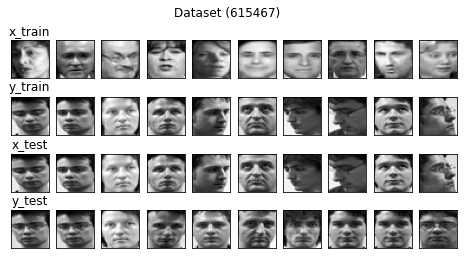

Epoch 1/2404
256/256 [==============================] - ETA: 0s - loss: 0.7086
Epoch 00001: loss improved from inf to 0.70855, saving model to models/7/Model-v7.h5


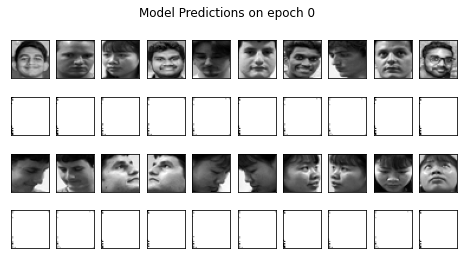

256/256 [==============================] - 184s 720ms/step - loss: 0.7086 - val_loss: 0.6930
Epoch 2/2404
256/256 [==============================] - ETA: 0s - loss: 0.6875
Epoch 00002: loss improved from 0.70855 to 0.68747, saving model to models/7/Model-v7.h5


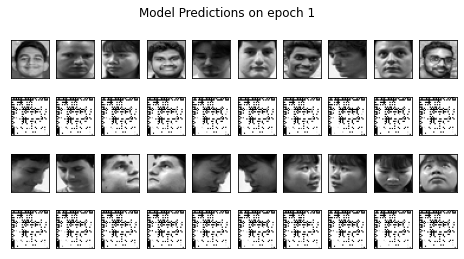

256/256 [==============================] - 182s 711ms/step - loss: 0.6875 - val_loss: 0.6907
Epoch 3/2404
256/256 [==============================] - ETA: 0s - loss: 0.6847
Epoch 00003: loss improved from 0.68747 to 0.68465, saving model to models/7/Model-v7.h5


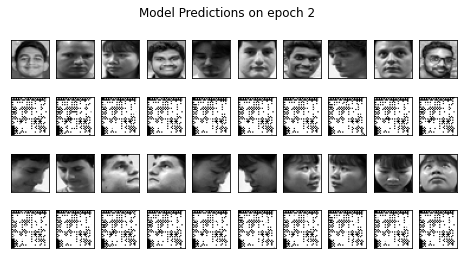

256/256 [==============================] - 182s 710ms/step - loss: 0.6847 - val_loss: 0.6920
Epoch 4/2404
256/256 [==============================] - ETA: 0s - loss: 0.6830
Epoch 00004: loss improved from 0.68465 to 0.68304, saving model to models/7/Model-v7.h5


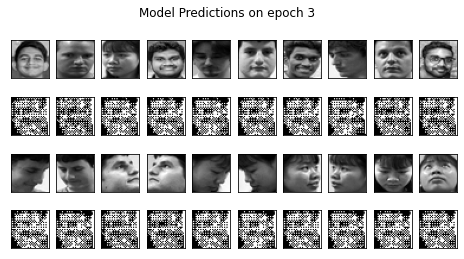

256/256 [==============================] - 191s 748ms/step - loss: 0.6830 - val_loss: 0.6946
Epoch 5/2404
256/256 [==============================] - ETA: 0s - loss: 0.6829
Epoch 00005: loss improved from 0.68304 to 0.68287, saving model to models/7/Model-v7.h5


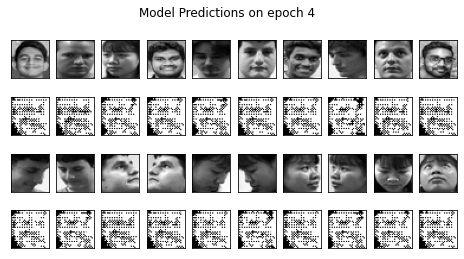

256/256 [==============================] - 192s 749ms/step - loss: 0.6829 - val_loss: 0.6917
Epoch 6/2404
256/256 [==============================] - ETA: 0s - loss: 0.6820
Epoch 00006: loss improved from 0.68287 to 0.68200, saving model to models/7/Model-v7.h5


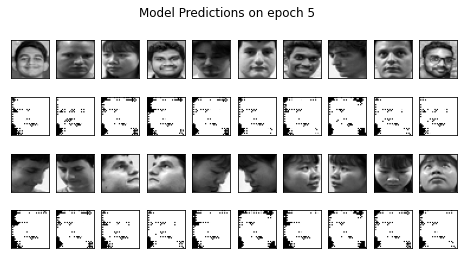

256/256 [==============================] - 191s 748ms/step - loss: 0.6820 - val_loss: 0.6934
Epoch 7/2404
256/256 [==============================] - ETA: 0s - loss: 0.6816
Epoch 00007: loss improved from 0.68200 to 0.68160, saving model to models/7/Model-v7.h5


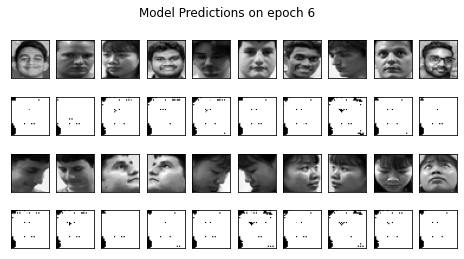

256/256 [==============================] - 192s 750ms/step - loss: 0.6816 - val_loss: 0.6921
Epoch 8/2404
256/256 [==============================] - ETA: 0s - loss: 0.6817
Epoch 00008: loss did not improve from 0.68160


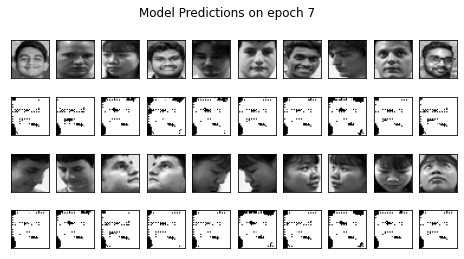

256/256 [==============================] - 191s 747ms/step - loss: 0.6817 - val_loss: 0.6930
Epoch 9/2404
256/256 [==============================] - ETA: 0s - loss: 0.6820
Epoch 00009: loss did not improve from 0.68160


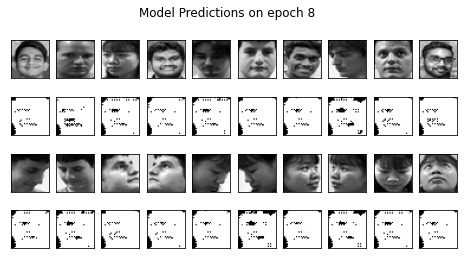

256/256 [==============================] - 191s 746ms/step - loss: 0.6820 - val_loss: 0.7062
Epoch 10/2404
256/256 [==============================] - ETA: 0s - loss: 0.6813
Epoch 00010: loss improved from 0.68160 to 0.68135, saving model to models/7/Model-v7.h5


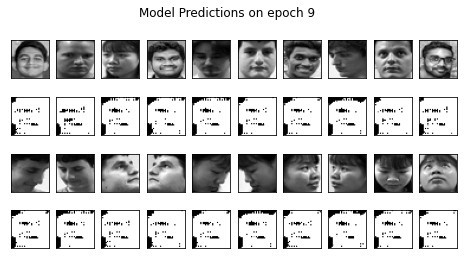

256/256 [==============================] - 193s 756ms/step - loss: 0.6813 - val_loss: 0.6945
Epoch 11/2404
256/256 [==============================] - ETA: 0s - loss: 0.6815
Epoch 00011: loss did not improve from 0.68135


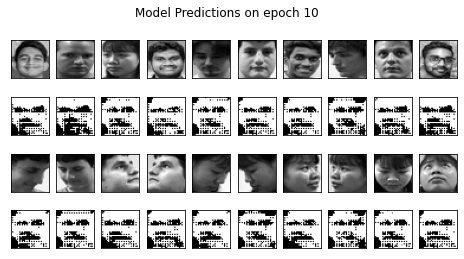

256/256 [==============================] - 197s 769ms/step - loss: 0.6815 - val_loss: 0.6935
Epoch 12/2404
256/256 [==============================] - ETA: 0s - loss: 0.6815
Epoch 00012: loss did not improve from 0.68135


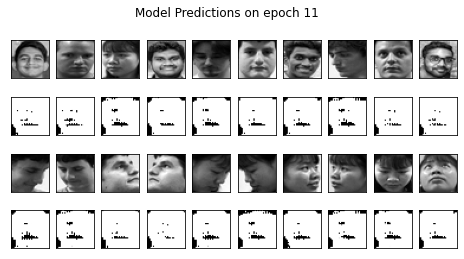

256/256 [==============================] - 196s 766ms/step - loss: 0.6815 - val_loss: 0.6977
Epoch 13/2404
256/256 [==============================] - ETA: 0s - loss: 0.6812
Epoch 00013: loss improved from 0.68135 to 0.68122, saving model to models/7/Model-v7.h5


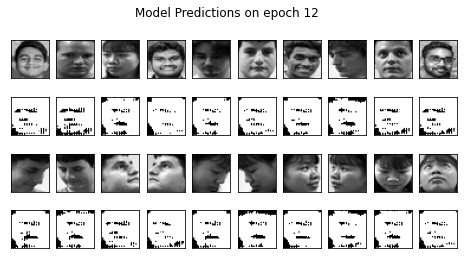

256/256 [==============================] - 193s 755ms/step - loss: 0.6812 - val_loss: 0.6922
Epoch 14/2404
256/256 [==============================] - ETA: 0s - loss: 0.6809
Epoch 00014: loss improved from 0.68122 to 0.68087, saving model to models/7/Model-v7.h5


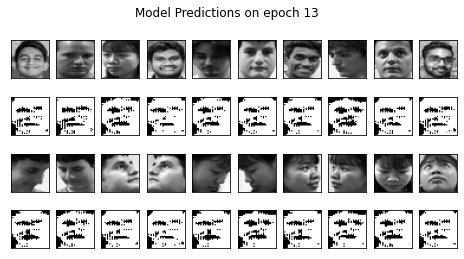

256/256 [==============================] - 193s 754ms/step - loss: 0.6809 - val_loss: 0.6919
Epoch 15/2404
256/256 [==============================] - ETA: 0s - loss: 0.6810
Epoch 00015: loss did not improve from 0.68087


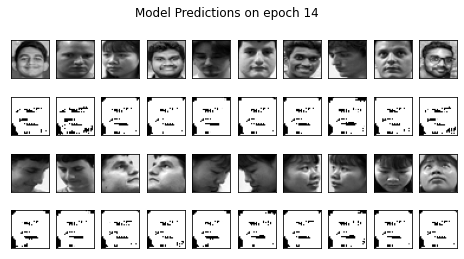

256/256 [==============================] - 195s 761ms/step - loss: 0.6810 - val_loss: 0.6910
Epoch 16/2404
256/256 [==============================] - ETA: 0s - loss: 0.6806
Epoch 00016: loss improved from 0.68087 to 0.68064, saving model to models/7/Model-v7.h5


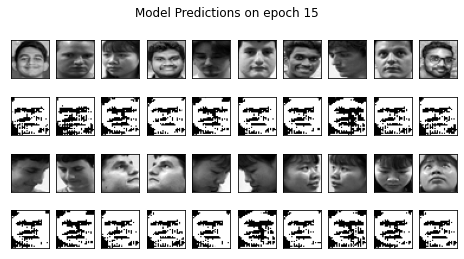

256/256 [==============================] - 193s 753ms/step - loss: 0.6806 - val_loss: 0.6926
Epoch 17/2404
256/256 [==============================] - ETA: 0s - loss: 0.6810
Epoch 00017: loss did not improve from 0.68064


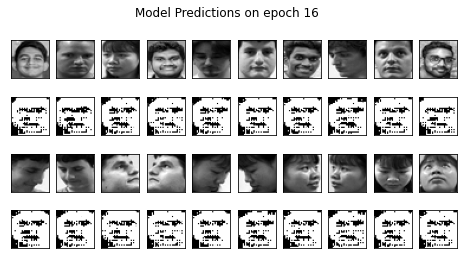

256/256 [==============================] - 193s 753ms/step - loss: 0.6810 - val_loss: 0.6919
Epoch 18/2404
256/256 [==============================] - ETA: 0s - loss: 0.6807
Epoch 00018: loss did not improve from 0.68064


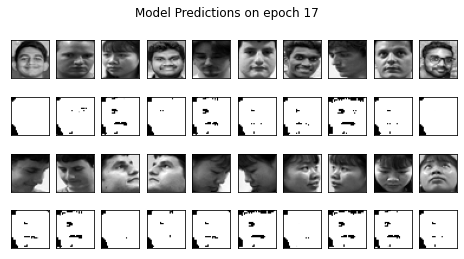

256/256 [==============================] - 192s 751ms/step - loss: 0.6807 - val_loss: 0.6973
Epoch 19/2404
256/256 [==============================] - ETA: 0s - loss: 0.6804
Epoch 00019: loss improved from 0.68064 to 0.68043, saving model to models/7/Model-v7.h5


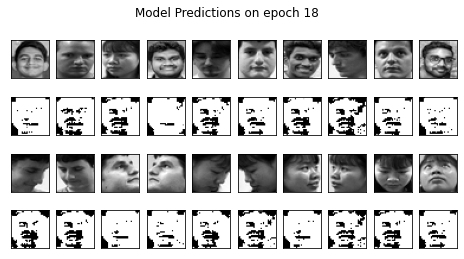

256/256 [==============================] - 193s 754ms/step - loss: 0.6804 - val_loss: 0.6932
Epoch 20/2404
256/256 [==============================] - ETA: 0s - loss: 0.6808
Epoch 00020: loss did not improve from 0.68043


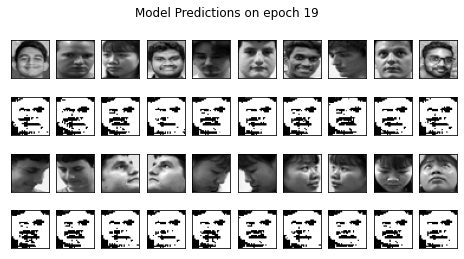

256/256 [==============================] - 192s 750ms/step - loss: 0.6808 - val_loss: 0.6919
Epoch 21/2404
256/256 [==============================] - ETA: 0s - loss: 0.6807
Epoch 00021: loss did not improve from 0.68043


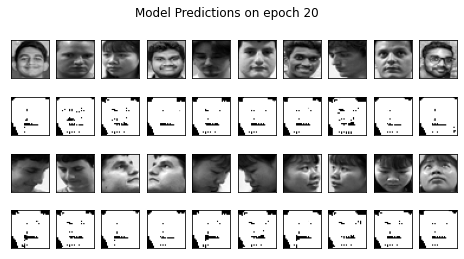

256/256 [==============================] - 191s 747ms/step - loss: 0.6807 - val_loss: 0.6948
Epoch 22/2404
256/256 [==============================] - ETA: 0s - loss: 0.6802
Epoch 00022: loss improved from 0.68043 to 0.68018, saving model to models/7/Model-v7.h5


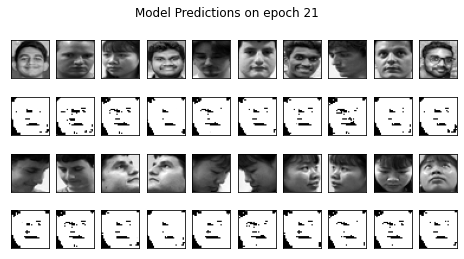

256/256 [==============================] - 192s 751ms/step - loss: 0.6802 - val_loss: 0.6926
Epoch 23/2404
256/256 [==============================] - ETA: 0s - loss: 0.6802
Epoch 00023: loss did not improve from 0.68018


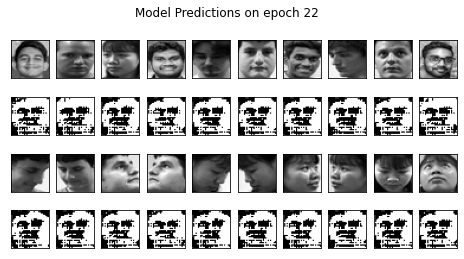

256/256 [==============================] - 192s 751ms/step - loss: 0.6802 - val_loss: 0.6932
Epoch 24/2404
256/256 [==============================] - ETA: 0s - loss: 0.6797
Epoch 00024: loss improved from 0.68018 to 0.67973, saving model to models/7/Model-v7.h5


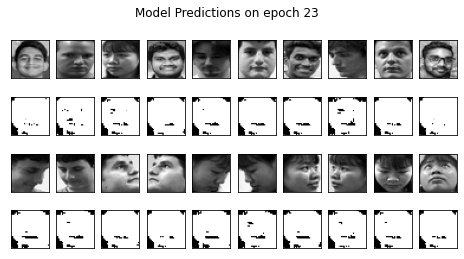

256/256 [==============================] - 193s 752ms/step - loss: 0.6797 - val_loss: 0.6917
Epoch 25/2404
256/256 [==============================] - ETA: 0s - loss: 0.6798
Epoch 00025: loss did not improve from 0.67973


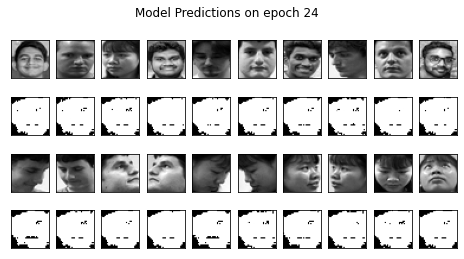

256/256 [==============================] - 192s 749ms/step - loss: 0.6798 - val_loss: 0.6940
Epoch 26/2404
256/256 [==============================] - ETA: 0s - loss: 0.6802
Epoch 00026: loss did not improve from 0.67973


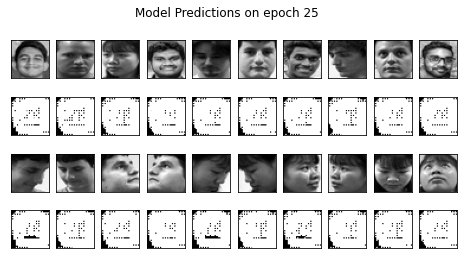

256/256 [==============================] - 194s 758ms/step - loss: 0.6802 - val_loss: 0.6952
Epoch 27/2404
256/256 [==============================] - ETA: 0s - loss: 0.6802
Epoch 00027: loss did not improve from 0.67973


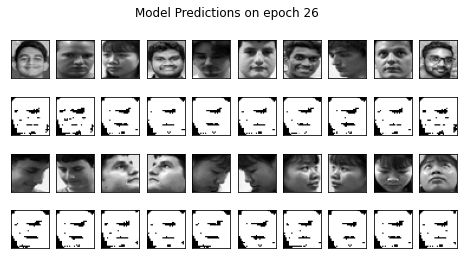

256/256 [==============================] - 194s 759ms/step - loss: 0.6802 - val_loss: 0.6938
Epoch 28/2404
256/256 [==============================] - ETA: 0s - loss: 0.6795
Epoch 00028: loss improved from 0.67973 to 0.67948, saving model to models/7/Model-v7.h5


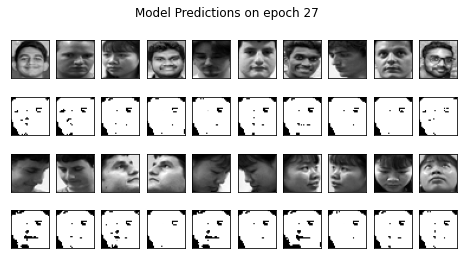

256/256 [==============================] - 193s 754ms/step - loss: 0.6795 - val_loss: 0.6928
Epoch 29/2404
256/256 [==============================] - ETA: 0s - loss: 0.6795
Epoch 00029: loss did not improve from 0.67948


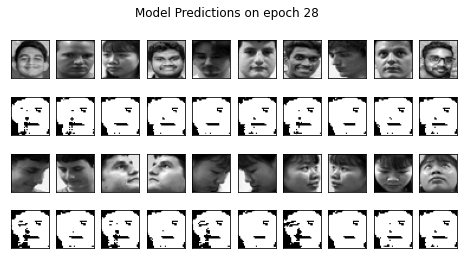

256/256 [==============================] - 193s 755ms/step - loss: 0.6795 - val_loss: 0.6934
Epoch 30/2404
256/256 [==============================] - ETA: 0s - loss: 0.6796
Epoch 00030: loss did not improve from 0.67948


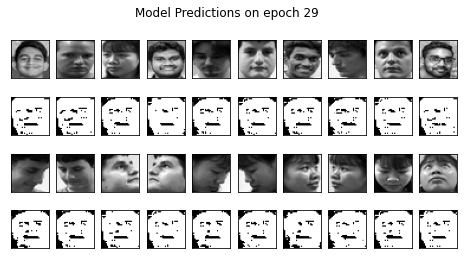

256/256 [==============================] - 192s 751ms/step - loss: 0.6796 - val_loss: 0.6934
Epoch 31/2404
256/256 [==============================] - ETA: 0s - loss: 0.6794
Epoch 00031: loss improved from 0.67948 to 0.67938, saving model to models/7/Model-v7.h5


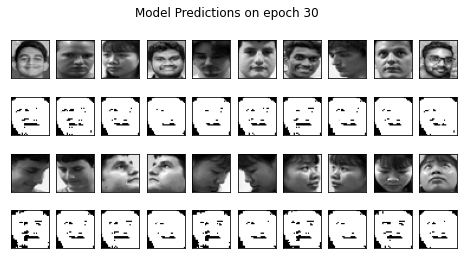

256/256 [==============================] - 193s 755ms/step - loss: 0.6794 - val_loss: 0.6922
Epoch 32/2404
256/256 [==============================] - ETA: 0s - loss: 0.6795
Epoch 00032: loss did not improve from 0.67938


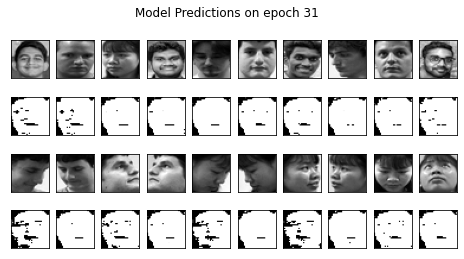

256/256 [==============================] - 193s 752ms/step - loss: 0.6795 - val_loss: 0.6941
Epoch 33/2404
256/256 [==============================] - ETA: 0s - loss: 0.6814
Epoch 00033: loss did not improve from 0.67938


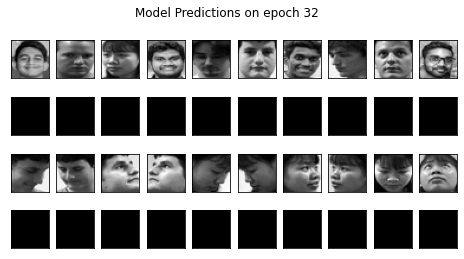

256/256 [==============================] - 191s 748ms/step - loss: 0.6814 - val_loss: 0.6931
Epoch 34/2404
256/256 [==============================] - ETA: 0s - loss: 0.6931
Epoch 00034: loss did not improve from 0.67938


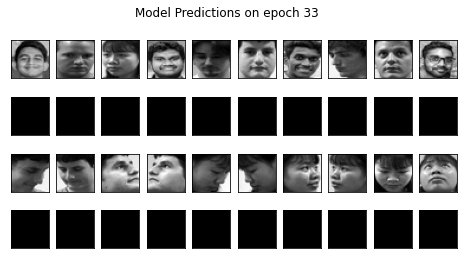

256/256 [==============================] - 187s 730ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 35/2404
256/256 [==============================] - ETA: 0s - loss: 0.6931
Epoch 00035: loss did not improve from 0.67938


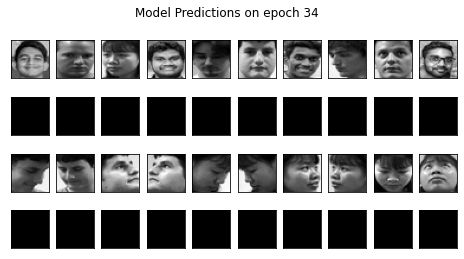

256/256 [==============================] - 187s 732ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 36/2404
256/256 [==============================] - ETA: 0s - loss: 0.6931
Epoch 00036: loss did not improve from 0.67938


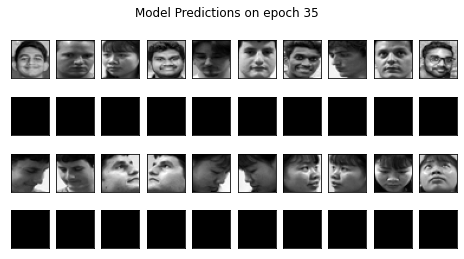

256/256 [==============================] - 187s 730ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 37/2404
256/256 [==============================] - ETA: 0s - loss: 0.6931
Epoch 00037: loss did not improve from 0.67938


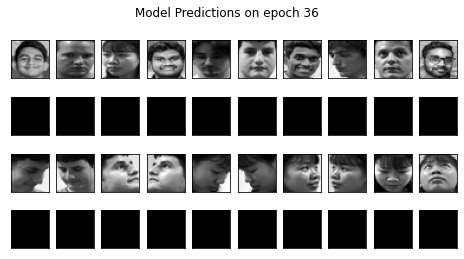

256/256 [==============================] - 186s 728ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 38/2404
145/256 [===============>..............] - ETA: 1:17 - loss: 0.6931WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 615424 batches). You may need to use the repeat() function when building your dataset.

Epoch 00038: loss did not improve from 0.67938


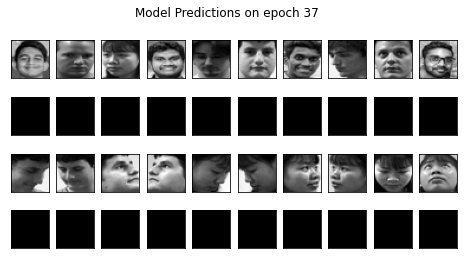

145/256 [===============>..............] - 113s 777ms/step - loss: 0.6931 - val_loss: 0.6931


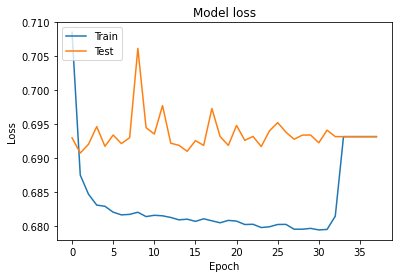

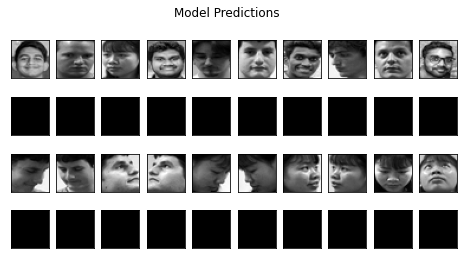

In [6]:
speculo.train()